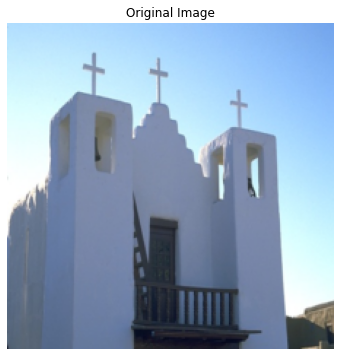

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import sys
import os
import matplotlib as mpl

parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.insert(0, parent_dir)


# Load and preprocess the image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

cmap = mpl.colors.ListedColormap(torch.rand(224, 3).numpy())  # You can customize the colormap if desired

# Replace 'your_image.jpg' with the path to your image
image = Image.open(r"D:\Data\BSDS500\data\images\train\24063.jpg").convert('RGB')
img_tensor = transform(image).unsqueeze(0)  # [1, C, H, W]

# Display the original image
plt.figure(figsize=(6, 6))
plt.imshow(img_tensor.cpu()[0].permute(1, 2, 0))
plt.title('Original Image')
plt.axis('off')
plt.show()

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import segmentation_models_pytorch as smp
import math

from torch_scatter import scatter_mean

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import segmentation_models_pytorch as smp


class VoronoiPropagation(nn.Module):
    def __init__(self, num_clusters=196, height=224, width=224, device='cpu'):
        """
        Args:
            num_clusters (int): Number of clusters (centroids) to initialize.
            height (int): Height of the input image.
            width (int): Width of the input image.
            device (str): Device to run the model ('cpu' or 'cuda').
        """
        super(VoronoiPropagation, self).__init__()
        
        self.C = num_clusters
        self.H = height
        self.W = width
        self.device = torch.device(device)
        
        # self.unet = smp.Unet(encoder_name="efficientnet-b0",
        #                      encoder_weights="imagenet",  
        #                      in_channels=3,               
        #                      classes=3)   
        
        # Set bandwidth / sigma for kernel
        self.std = self.C / (self.H * self.W)**0.5
        
        self.convert_to_greyscale = torchvision.transforms.Grayscale(num_output_channels=1)

    def compute_gradient_map(self, x):
        # Sobel kernels for single-channel input
        sobel_x = torch.tensor([[[[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]]], device=x.device, dtype=x.dtype)
        sobel_y = torch.tensor([[[[-1, -2, -1], [0, 0, 0], [1, 2, 1]]]], device=x.device, dtype=x.dtype)
        
        # Apply Sobel filters
        grad_x = F.conv2d(x, sobel_x, padding=1)
        grad_y = F.conv2d(x, sobel_y, padding=1)
        
        # Compute gradient magnitude
        grad_map = torch.sqrt(grad_x.pow(2) + grad_y.pow(2))
        return grad_map

    def place_centroids_on_grid(self, batch_size):
        num_cols = int(math.sqrt(self.C * self.W / self.H))
        num_rows = int(math.ceil(self.C / num_cols))

        grid_spacing_y = self.H / num_rows
        grid_spacing_x = self.W / num_cols

        centroids = []
        for i in range(num_rows):
            for j in range(num_cols):
                if len(centroids) >= self.C:
                    break
                y = int((i + 0.5) * grid_spacing_y)
                x = int((j + 0.5) * grid_spacing_x)
                centroids.append([y, x])
            if len(centroids) >= self.C:
                break

        centroids = torch.tensor(centroids, device=self.device).float()
        return centroids.unsqueeze(0).repeat(batch_size, 1, 1)

    def find_nearest_minima(self, centroids, grad_map, neighborhood_size=10):
        updated_centroids = []
        B, _, _ = centroids.shape
        
        for batch_idx in range(B):
            updated_centroids_batch = []
            occupied_positions = set()
            for centroid in centroids[batch_idx]:
                y, x = centroid
                y_min = max(0, int(y) - neighborhood_size)
                y_max = min(self.H, int(y) + neighborhood_size)
                x_min = max(0, int(x) - neighborhood_size)
                x_max = min(self.W, int(x) + neighborhood_size)
                
                neighborhood = grad_map[batch_idx, 0, y_min:y_max, x_min:x_max]
                min_val = torch.min(neighborhood)
                min_coords = torch.nonzero(neighborhood == min_val, as_tuple=False)
                
                # Iterate over all minima to find an unoccupied one
                found = False
                for coord in min_coords:
                    new_y = y_min + coord[0].item()
                    new_x = x_min + coord[1].item()
                    position = (new_y, new_x)
                    if position not in occupied_positions:
                        occupied_positions.add(position)
                        updated_centroids_batch.append([new_y, new_x])
                        found = True
                        break
                if not found:
                    # If all minima are occupied, keep the original position
                    updated_centroids_batch.append([y.item(), x.item()])
            
            updated_centroids.append(torch.tensor(updated_centroids_batch, device=self.device))
        
        return torch.stack(updated_centroids, dim=0)

    def distance_weighted_propagation(self, centroids, grad_map, color_map, num_iters=50, gradient_weight=10.0, color_weight=10.0, edge_exponent=4.0): # gradient weight, color weight and edge exponent are all tuneable parameters 
        """
        Perform Voronoi-like propagation from centroids, guided by both the gradient map and color similarity.
        
        Args:
            centroids (Tensor): Initial centroid positions.
            grad_map (Tensor): Gradient magnitude map.
            color_map (Tensor): Input image for color similarity.
            num_iters (int): Number of iterations to perform propagation.
            gradient_weight (float): Weight for the gradient penalty.
            color_weight (float): Weight for the color similarity penalty.
            edge_exponent (float): Exponent to amplify edge gradients.
        
        Returns:
            Tensor: Final segmentation mask.
        """
        B, _, H, W = grad_map.shape
        mask = torch.full((B, H, W), fill_value=-1, device=grad_map.device)  # Label mask
        dist_map = torch.full((B, H, W), fill_value=float('inf'), device=grad_map.device)  # Distance map
        
        for batch_idx in range(B):
            for idx, (cy, cx) in enumerate(centroids[batch_idx]):
                mask[batch_idx, int(cy), int(cx)] = idx
                dist_map[batch_idx, int(cy), int(cx)] = 0  # Distance from centroid is 0 initially
        
        # 4-connected neighbors (dy, dx)
        directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]
        
        # Amplify the impact of the gradient map by multiplying it with a weight and applying a non-linear transformation
        weighted_grad_map = (grad_map ** edge_exponent) * gradient_weight

        # Perform propagation with both gradient penalties and color similarity
        for _ in range(num_iters):
            for dy, dx in directions:
                # Shift the distance map in each direction
                shifted_dist = torch.roll(dist_map, shifts=(dy, dx), dims=(1, 2))
                shifted_mask = torch.roll(mask, shifts=(dy, dx), dims=(1, 2))
                
                # Calculate color distance between current pixel and centroid it is being propagated from
                color_diff = torch.abs(color_map - torch.roll(color_map, shifts=(dy, dx), dims=(2, 3))).sum(dim=1)  # Sum over color channels

                # Add the gradient map value as a weighted penalty to the distance
                weighted_dist = shifted_dist + weighted_grad_map[:, 0, :, :] + color_diff * color_weight
                
                # Update the mask and distance map where the new combined distance is smaller
                update_mask = weighted_dist < dist_map
                dist_map[update_mask] = weighted_dist[update_mask]
                mask[update_mask] = shifted_mask[update_mask]
        
        return mask
        
    def forward(self, x):
        B, C_in, H, W = x.shape
        
        if C_in == 3:
            grayscale_image = self.convert_to_greyscale(x)
        else:
            grayscale_image = x
        
        # Compute the gradient map from grayscale image
        grad_map = self.compute_gradient_map(grayscale_image)
        
        # Place centroids on a grid
        centroids = self.place_centroids_on_grid(B)
        
        # Move centroids to nearest local minima
        centroids = self.find_nearest_minima(centroids, grad_map)
        
        # Use the color map (the original image) to guide propagation
        # spixel_features = self.unet(x)
        
        # Perform distance-weighted propagation with both gradient and color guidance
        mask = self.distance_weighted_propagation(centroids, grad_map, x)
        
        # return grad_map, centroids, mask, spixel_features
        return grad_map, centroids, mask# , x

    
class DifferentiableSuperpixelTokenizer(nn.Module):
    def __init__(self, max_segments, n_channels=3, embed_dim=768):
        super().__init__()
        self.superpixel_tokenizer = VoronoiPropagation(max_segments)
        self.max_segments = max_segments
        self.embed_dim = embed_dim

        # CNN backbone to extract feature maps
        self.cnn = nn.Sequential(
            nn.Conv2d(n_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, embed_dim, kernel_size=3, stride=1, padding=2, dilation=2),
            nn.BatchNorm2d(embed_dim),
            nn.ReLU(),
        )

        # Linear layer to project centroid coordinates to positional embeddings
        self.positional_embedding = nn.Linear(2, embed_dim)

    def forward(self, img):
        # Get the superpixel segments and centroid coordinates from the tokenizer
        gradient_map, centroid_coords, segments = self.superpixel_tokenizer(img)

        batch_size, n_channels, height, width = img.shape

        # Process the image with CNN to get feature maps
        features = self.cnn(img)  # features: [B, C, H, W]
        B, C, Hf, Wf = features.shape

        # Flatten features and segments
        features_flat = features.permute(0, 2, 3, 1).reshape(-1, C)  # [B * Hf * Wf, embed_dim]
        segments_flat = segments.view(-1)  # [B * Hf * Wf]

        # Create batch indices
        batch_indices = torch.arange(B, device=img.device).unsqueeze(1).expand(B, Hf * Wf).reshape(-1)

        # Compute unique segment IDs per batch
        unique_segment_ids = batch_indices * self.max_segments + segments_flat  # [B * Hf * Wf]

        # Compute per-segment embeddings using scatter_mean
        dim_size = B * self.max_segments
        embeddings = scatter_mean(features_flat, unique_segment_ids, dim=0, dim_size=dim_size)
        embeddings = embeddings.view(B, self.max_segments, C)  # [B, max_segments, embed_dim]

        # Compute variance of features within superpixels
        feature_variance = scatter_mean(features_flat ** 2, unique_segment_ids, dim=0, dim_size=dim_size) - embeddings.view(-1, embeddings.size(-1)) ** 2
        feature_variance = feature_variance.view(B, self.max_segments, C).mean(dim=-1)  # [B, max_segments]

        # Normalize centroid coordinates for positional embeddings
        centroids_normalized = centroid_coords.clone().float()
        centroids_normalized[:, :, 0] /= float(width)
        centroids_normalized[:, :, 1] /= float(height)

        # Project centroid coordinates to positional embeddings
        pos_embeddings = self.positional_embedding(centroids_normalized.to(img.device))  # [B, n_centroids, embed_dim]

        # Pad positional embeddings to match max_segments
        pos_embeddings_padded = torch.zeros(B, self.max_segments, self.embed_dim, device=img.device)
        n_centroids = centroids_normalized.shape[1]
        if n_centroids > self.max_segments:
            pos_embeddings_padded = pos_embeddings[:, :self.max_segments, :]
        else:
            pos_embeddings_padded[:, :n_centroids, :] = pos_embeddings

        # Combine embeddings with positional embeddings
        embeddings = embeddings + pos_embeddings_padded

        # Return necessary outputs for visualization
        return {
            'embeddings': embeddings,  # [B, max_segments, embed_dim]
            'features_flat': features_flat,  # [B * Hf * Wf, embed_dim]
            'segments': segments,  # [B, Hf, Wf]
            'unique_segment_ids': unique_segment_ids,  # [B * Hf * Wf]
            'pos_embeddings': pos_embeddings_padded,  # [B, max_segments, embed_dim]
            'feature_variance': feature_variance,  # [B, max_segments]
        }



    

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

# Helper function to visualize tensors
def visualize_tensor(tensor, title="Tensor", cmap="viridis"):
    if tensor.ndim == 3:  # If it's an image tensor with channels
        tensor = tensor.permute(1, 2, 0).cpu().numpy()  # Convert to H x W x C
    elif tensor.ndim == 2:  # If it's a 2D tensor
        tensor = tensor.cpu().numpy()

    plt.figure()
    plt.title(title)
    plt.imshow(tensor, cmap=cmap)
    plt.axis("off")
    plt.show()

# Visualize the DifferentiableSuperpixelTokenizer steps
def visualize_tokenizer_steps_with_features(model, img):
    with torch.no_grad():
        # Forward pass through the model
        gradient_map, centroid_coords, segments = model.superpixel_tokenizer(img)
        features = model.cnn(img)
        results = model(img)
        
    return {
            'embeddings': embeddings,  # [B, max_segments, embed_dim]
            'features_flat': features_flat,  # [B * Hf * Wf, embed_dim]
            'segments': segments,  # [B, Hf, Wf]
            'unique_segment_ids': unique_segment_ids,  # [B * Hf * Wf]
            'pos_embeddings': pos_embeddings_padded,  # [B, max_segments, embed_dim]
            'feature_variance': feature_variance,  # [B, max_segments]
        }
    
    embeddings = results['embeddings']
    features_flat = results['features_flat']
    segments = results['segments']
    unique_segment_ids = results['unique_segment_ids']
    pos_embeddings = results['pos_embeddings_padded']
    feature_variance = results['feature_variance']

    # Convert tensor to numpy array for visualization
    img_np = img[0].permute(1, 2, 0).cpu().numpy()  # Shape: [H, W, C]
    gradient_map_np = gradient_map[0][0].cpu().numpy()  # Shape: [H, W]
    segments_np = segments[0].cpu().numpy()  # Shape: [H, W]
    centroids_np = centroid_coords[0].cpu().numpy()  # Shape: [n_centroids, 2]
    embeddings_np = embeddings[0].cpu().numpy()  # Shape: [max_segments, embed_dim]
    
    # Compute mean positional embeddings per segment
    mean_pos_embeddings = embeddings_np.mean(axis=1)  # Mean over embedding dimensions

    # Plot input image
    plt.figure(figsize=(18, 12))
    plt.subplot(2, 3, 1)
    plt.imshow(img_np)
    plt.title("Input Image")
    plt.axis("off")

    # Plot gradient map
    plt.subplot(2, 3, 2)
    plt.imshow(gradient_map_np, cmap="gray")
    plt.title("Gradient Map")
    plt.axis("off")

    # Plot superpixel segments
    plt.subplot(2, 3, 3)
    plt.imshow(segments_np, cmap=cmap)
    plt.title("Superpixel Segments")
    plt.axis("off")

    # Overlay centroids on segments
    plt.subplot(2, 3, 4)
    plt.imshow(segments_np, cmap=cmap)
    plt.scatter(centroids_np[:, 0], centroids_np[:, 1], c="red", marker="x")
    plt.title("Centroids on Segments")
    plt.axis("off")

    # Plot positional embeddings as a heatmap
    plt.subplot(2, 3, 5)
    plt.imshow(mean_pos_embeddings[:segments_np.max() + 1].reshape(-1, 1), aspect="auto", cmap="viridis")
    plt.colorbar()
    plt.title("Positional Embeddings (Mean Heatmap)")
    plt.xlabel("Embedding Dimension")
    plt.ylabel("Segment Index")

    # Visualize mean segmented features
    H, W = segments_np.shape
    segmented_features = np.zeros((H, W))
    for seg_id in range(segments_np.max() + 1):
        mask = segments_np == seg_id
        feature_mean = features[0, :, mask].mean(dim=1).cpu().numpy()  # Mean of features in the segment
        segmented_features[mask] = feature_mean.mean()  # Use mean across feature dimensions

    plt.subplot(2, 3, 6)
    plt.imshow(segmented_features)
    plt.title("Segmented Features (Mean Values)")
    plt.colorbar()
    plt.axis("off")

    plt.tight_layout()
    plt.show()

model = DifferentiableSuperpixelTokenizer(196)

# Visualize the steps
visualize_tokenizer_steps_with_features(model, img_tensor)

KeyError: 0

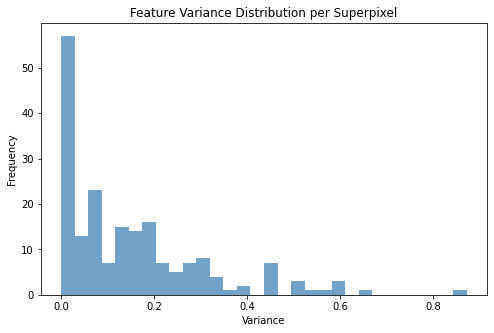

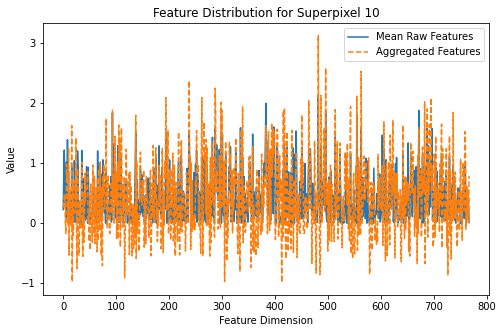

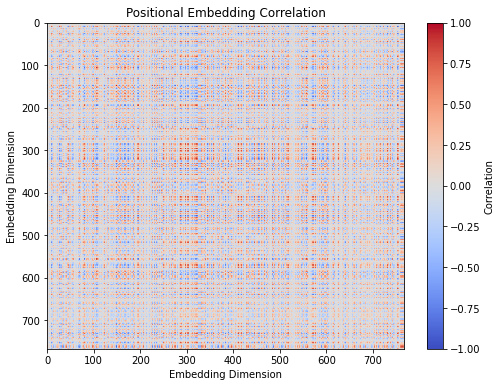

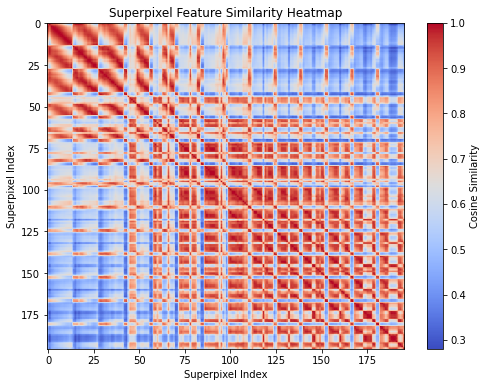

In [22]:
def visualize_tokenizer_results(results, batch_idx=0):
    import matplotlib.pyplot as plt
    from sklearn.metrics.pairwise import cosine_similarity

    # Extract results for the specified batch
    embeddings = results['embeddings'][batch_idx]
    features_flat = results['features_flat']
    segments = results['segments'][batch_idx]
    unique_segment_ids = results['unique_segment_ids']
    pos_embeddings = results['pos_embeddings'][batch_idx]
    feature_variance = results['feature_variance'][batch_idx]

    # 1. Per-Superpixel Feature Variance
    plt.figure(figsize=(8, 5))
    plt.hist(feature_variance.detach().numpy(), bins=30, alpha=0.75, color='steelblue')
    plt.title("Feature Variance Distribution per Superpixel")
    plt.xlabel("Variance")
    plt.ylabel("Frequency")
    plt.show()

    # 2. Per-Superpixel Feature Distribution
    superpixel_id = 10  # Example superpixel
    mask = (unique_segment_ids == superpixel_id)
    raw_features = features_flat[mask]
    aggregated_features = embeddings[superpixel_id]
    plt.figure(figsize=(8, 5))
    plt.plot(raw_features.mean(dim=0).detach().numpy(), label='Mean Raw Features')
    plt.plot(aggregated_features.detach().numpy(), label='Aggregated Features', linestyle='--')
    plt.legend()
    plt.title(f"Feature Distribution for Superpixel {superpixel_id}")
    plt.xlabel("Feature Dimension")
    plt.ylabel("Value")
    plt.show()

    # 4. Positional Embeddings Correlation
    pos_corr = torch.corrcoef(pos_embeddings.view(-1, pos_embeddings.size(-1)).T)
    plt.figure(figsize=(8, 6))
    plt.imshow(pos_corr.detach().numpy(), cmap='coolwarm', aspect='auto')
    plt.colorbar(label="Correlation")
    plt.title("Positional Embedding Correlation")
    plt.xlabel("Embedding Dimension")
    plt.ylabel("Embedding Dimension")
    plt.show()

    # 5. Superpixel Feature Similarity Heatmap
    similarity_matrix = cosine_similarity(embeddings.detach().numpy())
    plt.figure(figsize=(8, 6))
    plt.imshow(similarity_matrix, cmap="coolwarm", aspect='auto')
    plt.colorbar(label="Cosine Similarity")
    plt.title("Superpixel Feature Similarity Heatmap")
    plt.xlabel("Superpixel Index")
    plt.ylabel("Superpixel Index")
    plt.show()
    
model = DifferentiableSuperpixelTokenizer(196)
    
# Run the tokenizer and collect outputs
results = model(img_tensor)  # Assuming `img` is your input tensor

# Visualize the results for batch index 0
visualize_tokenizer_results(results, batch_idx=0)

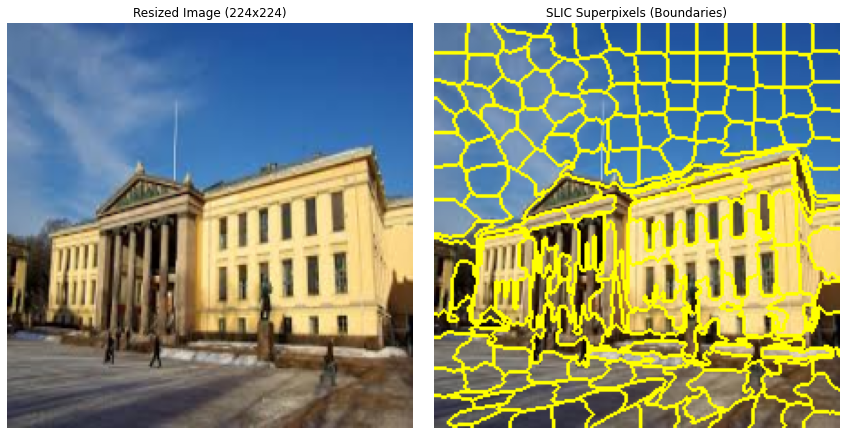

In [5]:
# Jupyter Notebook cell

import matplotlib.pyplot as plt
import numpy as np

from skimage.io import imread
from skimage.transform import resize
from skimage.segmentation import slic, mark_boundaries
from skimage.util import img_as_float

def visualize_superpixels_224(image_path, 
                              n_segments=100, 
                              compactness=10, 
                              sigma=1):
    """
    1. Loads an image from 'image_path'
    2. Resizes it to 224x224
    3. Applies SLIC superpixel segmentation
    4. Plots the original vs. superpixel boundaries

    :param image_path: Path to the input image
    :param n_segments: Approximate number of superpixels to generate
    :param compactness: Balances color-space proximity and image-space proximity
    :param sigma: Width of Gaussian smoothing kernel for preprocessing
    """
    # Load the image
    image = imread(image_path)
    
    # Convert to float in [0,1] for SLIC
    image_float = img_as_float(image)
    
    # Resize to 224x224
    image_resized = resize(image_float, (224, 224), anti_aliasing=True)
    
    # Generate superpixels with SLIC
    segments = slic(
        image_resized,
        n_segments=n_segments,
        compactness=compactness,
        sigma=sigma,
        start_label=1
    )
    
    # Mark boundaries on the original image for visualization
    marked = mark_boundaries(image_resized, segments)

    # Create a figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    ax1, ax2 = axes

    # Show resized image
    ax1.imshow(image_resized)
    ax1.set_title("Resized Image (224x224)")
    ax1.axis("off")

    # Show superpixel boundaries
    ax2.imshow(marked)
    ax2.set_title("SLIC Superpixels (Boundaries)")
    ax2.axis("off")

    plt.tight_layout()
    plt.show()

# Example usage:
image_path = r"D:\MSc_Data_Science_UiO\Thesis\learnableTokenizer\figures\patchTokenizer\university_building_example_wiki.jpg"
visualize_superpixels_224(
    image_path, 
    n_segments=196,   # Increase segments for finer superpixel detail
    compactness=10,   # Adjust to get more "square" superpixels or not
    sigma=1
)


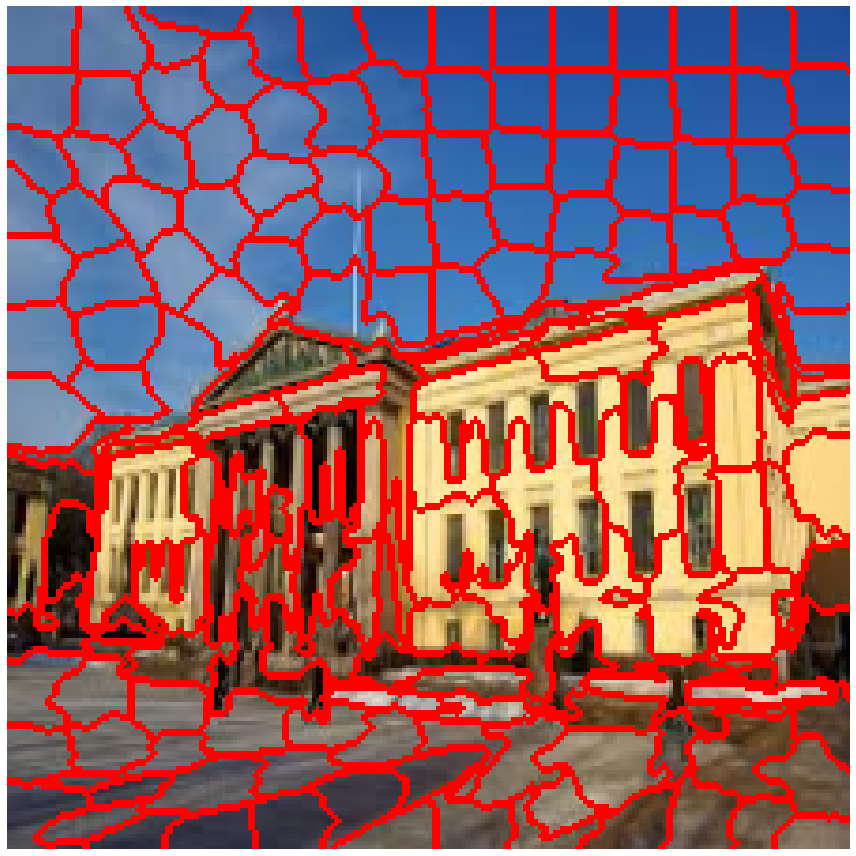

In [14]:
import matplotlib.pyplot as plt
import numpy as np

from skimage.io import imread
from skimage.transform import resize
from skimage.segmentation import slic, mark_boundaries
from skimage.util import img_as_float

def visualize_superpixels_224_custom_outline(image_path, 
                                             n_segments=100, 
                                             compactness=10, 
                                             sigma=1, 
                                             boundary_color=(1, 0, 0)):
    """
    1. Loads an image from 'image_path'
    2. Resizes it to 224x224
    3. Applies SLIC superpixel segmentation
    4. Plots ONLY the superpixel boundaries, using a custom boundary color.

    :param image_path: Path to the input image
    :param n_segments: Approx number of superpixels
    :param compactness: Balances color vs. spatial proximity
    :param sigma: Gaussian smoothing prior to segmentation
    :param boundary_color: (R, G, B) tuple for boundary color
    """
    # Load the image
    image = imread(image_path)
    
    # Convert to float in [0,1] for SLIC
    image_float = img_as_float(image)
    
    # Resize to 224x224
    image_resized = resize(image_float, (224, 224), anti_aliasing=True)
    
    # Generate superpixels with SLIC
    segments = slic(
        image_resized,
        n_segments=n_segments,
        compactness=compactness,
        sigma=sigma,
        start_label=1
    )
    
    # Mark boundaries on the image using a custom color
    marked = mark_boundaries(image_resized, segments, color=boundary_color)

    # Plot only the superpixel boundaries
    plt.figure(figsize=(12, 12))
    plt.imshow(marked)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

# Example usage:
image_path = r"D:\MSc_Data_Science_UiO\Thesis\learnableTokenizer\figures\patchTokenizer\university_building_example_wiki.jpg"
visualize_superpixels_224_custom_outline(
    image_path, 
    n_segments=196,  
    compactness=10,  
    sigma=1,
    boundary_color=(1, 0, 0)  # RED boundary
)
